In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.decomposition import PCA # Principal Component Analysis module
from sklearn.cluster import KMeans # KMeans clustering 
import matplotlib.pyplot as plt # Python defacto plotting library
import seaborn as sns # More snazzy plotting library
import pylab as pl
%matplotlib inline 

In [4]:
#TCP Conn Logs
# import pandas as pd
# import os
# os.chdir("/home/rk9cx/HP/")
# df = pd.read_csv("10_08_conn_logs_tcp.csv", index_col=False, header=None)
# df.columns =["ts","uid","src_ip","src_port","resp_ip","resp_port","duration","orig_bytes","resp_bytes","conn_state",
#              "history","orig_pkts","resp_pkts","tunnel_parents","local"]
# cols_num = ["resp_port","duration","orig_bytes","resp_bytes","orig_pkts","resp_pkts"]
# df[cols_num] = df[cols_num].apply(pd.to_numeric, errors='coerce')
# cols_char = ["src_ip","resp_ip"]
# df[cols_char] = df[cols_char].astype(str)
df.head()

,ts,uid,src_ip,src_port,resp_ip,resp_port,duration,orig_bytes,resp_bytes,conn_state,history,orig_pkts,resp_pkts,tunnel_parents,local
0,1.533874e+09,CIf9R7a16hMfT1A9e,122.226.181.166,50306,3.110.155.144,22,12.026488,1375.0,1704.0,SF,ShADadFf,22,20,(empty),0
1,1.533874e+09,C1C2Tb4r1J2DsQMEma,88.248.122.27,61411,3.110.25.97,23,NaN,NaN,NaN,S0,S,1,0,(empty),0
2,1.533874e+09,CNaKbk2pXjxS0WkAii,122.226.181.166,34618,3.110.111.183,22,7.877663,1375.0,2864.0,SF,ShADadFf,17,20,(empty),0
3,1.533874e+09,CfYWQJ1KeegkaaqwUj,122.226.181.166,44918,3.110.111.171,22,10.098120,1375.0,2863.0,SF,ShADadFf,20,20,(empty),0
4,1.533874e+09,CqupzN2O7x8QTIxQf2,221.230.7.85,52333,3.110.66.196,23,NaN,NaN,NaN,S0,S,1,0,(empty),0


In [3]:
df_clean = pd.DataFrame(df.groupby('src_ip').agg({'src_port': 'nunique','resp_port': 'nunique', 'resp_ip': 'nunique',
                                                  'duration': 'mean','orig_bytes':'sum',
                                                  'resp_bytes':'sum','orig_pkts':'sum',
                                                  'resp_pkts':'sum'}))
df_clean.reset_index(inplace=True)
df_clean.head()

,src_ip,src_port,resp_port,resp_ip,duration,orig_bytes,resp_bytes,orig_pkts,resp_pkts
0,1.53.27.40,83,2,4792,5.744794,1820.0,10154.0,5737,876
1,1.54.120.44,12,2,2901,0.586268,0.0,0.0,2981,59
2,1.85.124.153,22,1,22,2.998183,0.0,0.0,66,0
3,100.6.124.25,3,38,115,3.818953,124.0,2166.0,138,25
4,103.115.196.59,48,3,47,2.541587,298.0,3646.0,67,23


In [8]:
df_clean = df_clean.dropna()
df_clean.shape

(335, 9)

In [9]:
Y = df_clean.loc[:,df_clean.columns == 'src_ip']
X = df_clean.loc[:, df_clean.columns != 'src_ip']

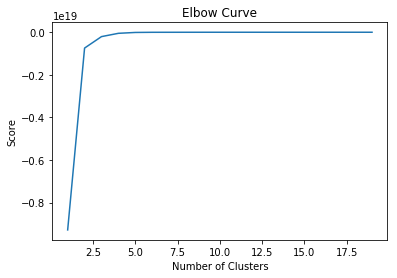

In [10]:
Nc = range(1, 20)
kmeans = [KMeans(n_clusters=i) for i in Nc]
score = [kmeans[i].fit(X).score(X) for i in range(len(kmeans))]
pl.plot(Nc,score)
pl.xlabel('Number of Clusters')
pl.ylabel('Score')
pl.title('Elbow Curve')
pl.show()

In [11]:
#Scaling 
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [12]:
km = KMeans(n_clusters=3).fit(X_scaled)
df_clean['cluster'] = km.labels_
X_scaled['cluster'] = km.labels_

In [13]:
df_clean["cluster"].unique()

array([1, 2, 0])

In [14]:
df_clean.groupby('cluster').size()

cluster
0     12
1    292
2     31
dtype: int64

In [15]:
final_df = df_clean

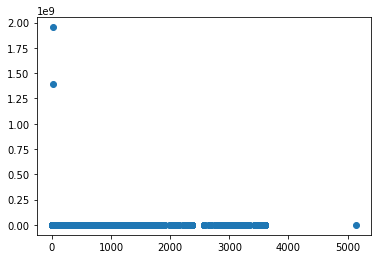

In [20]:
import numpy as np
import matplotlib.pyplot as plt
plt.scatter(df["orig_bytes"], df["resp_bytes"] )

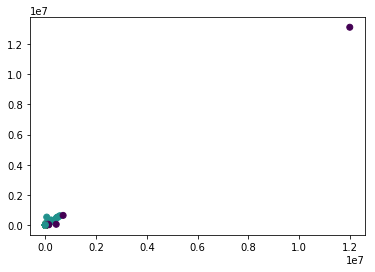

In [17]:
plt.scatter(final_df["orig_pkts"], final_df["resp_pkts"] , c=final_df["cluster"])

In [18]:
#removing outliers from pkts
p = final_df["orig_pkts"].quantile(0.99)
q = final_df["resp_pkts"].quantile(0.99)
r = final_df["orig_bytes"].quantile(0.99)
s = final_df["resp_bytes"].quantile(0.99)
test = final_df.loc[(final_df['orig_pkts'] < p) & (final_df['resp_pkts'] < q) &
                    (final_df['orig_bytes'] < r) & (final_df['resp_bytes'] < s),]
test.shape

(329, 10)

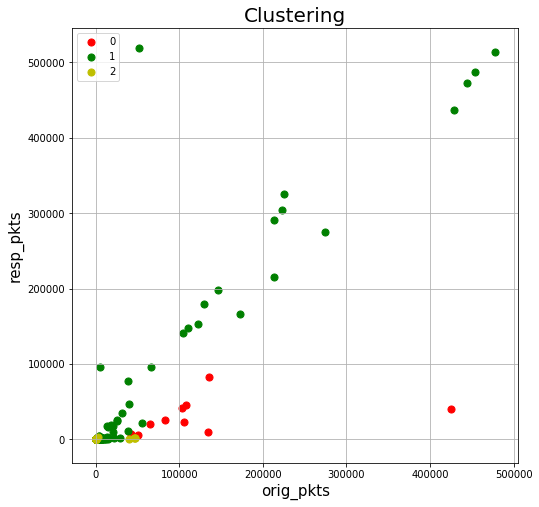

In [19]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('orig_pkts', fontsize = 15)
ax.set_ylabel('resp_pkts', fontsize = 15)
ax.set_title('Clustering', fontsize = 20)
targets = [0,1,2]
colors = ['r', 'g','y']
for target, color in zip(targets,colors):
    indicesToKeep = test['cluster'] == target
    ax.scatter(test.loc[indicesToKeep, 'orig_pkts']
               , test.loc[indicesToKeep, 'resp_pkts']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

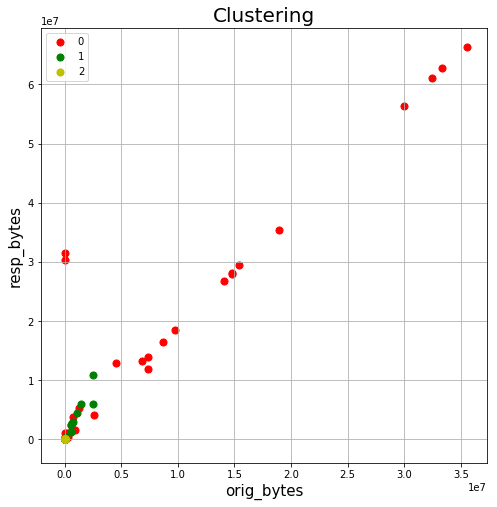

In [169]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('orig_bytes', fontsize = 15)
ax.set_ylabel('resp_bytes', fontsize = 15)
ax.set_title('Clustering', fontsize = 20)
targets = [0,1,2]
colors = ['r', 'g','y']
for target, color in zip(targets,colors):
    indicesToKeep = test['cluster'] == target
    ax.scatter(test.loc[indicesToKeep, 'orig_bytes']
               , test.loc[indicesToKeep, 'resp_bytes']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [122]:
#removing outliers from pkts
p = X_scaled["orig_pkts"].quantile(0.90)
q = X_scaled["resp_pkts"].quantile(0.90)
r = X_scaled["orig_bytes"].quantile(0.90)
s = X_scaled["resp_bytes"].quantile(0.90)
test = X_scaled.loc[(X_scaled['orig_pkts'] < p) & (X_scaled['orig_pkts'] < q) &
                    (X_scaled['orig_bytes'] < r) & (X_scaled['resp_bytes'] < s),]
test.shape

(287, 8)

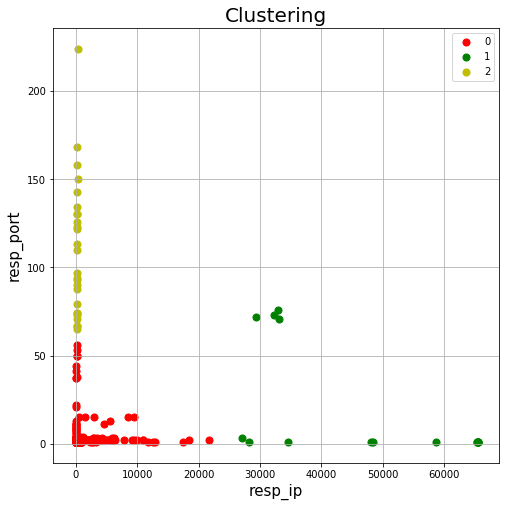

In [170]:
#plt.scatter(final_df["resp_ip"], final_df["resp_port"] , c=final_df["cluster"])
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('resp_ip', fontsize = 15)
ax.set_ylabel('resp_port', fontsize = 15)
ax.set_title('Clustering', fontsize = 20)
targets = [0,1,2]
colors = ['r', 'g','y']
for target, color in zip(targets,colors):
    indicesToKeep = test['cluster'] == target
    ax.scatter(test.loc[indicesToKeep, 'resp_ip']
               , test.loc[indicesToKeep, 'resp_port']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

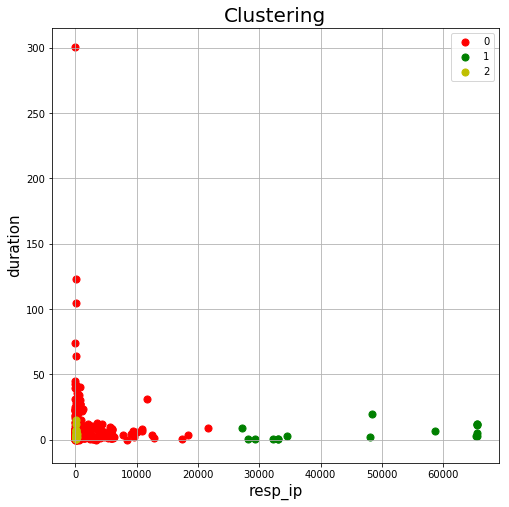

In [171]:
#plt.scatter(final_df["resp_ip"], final_df["duration"] , c=final_df["cluster"])
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('resp_ip', fontsize = 15)
ax.set_ylabel('duration', fontsize = 15)
ax.set_title('Clustering', fontsize = 20)
targets = [0,1,2]
colors = ['r', 'g','y']
for target, color in zip(targets,colors):
    indicesToKeep = test['cluster'] == target
    ax.scatter(test.loc[indicesToKeep, 'resp_ip']
               , test.loc[indicesToKeep, 'duration']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

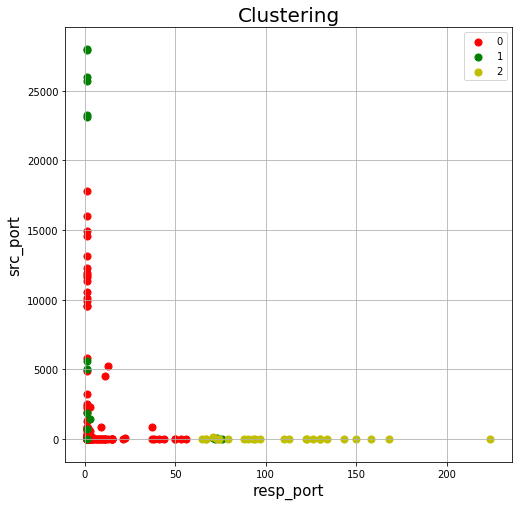

In [172]:
#plt.scatter(final_df["resp_port"], final_df["src_port"] , c=final_df["cluster"])
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('resp_port', fontsize = 15)
ax.set_ylabel('src_port', fontsize = 15)
ax.set_title('Clustering', fontsize = 20)
targets = [0,1,2]
colors = ['r', 'g','y']
for target, color in zip(targets,colors):
    indicesToKeep = test['cluster'] == target
    ax.scatter(test.loc[indicesToKeep, 'resp_port']
               , test.loc[indicesToKeep, 'src_port']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

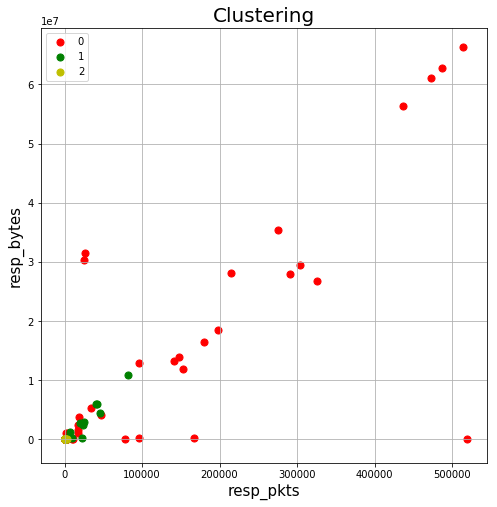

In [173]:
#plt.scatter(test["resp_pkts"], test["resp_bytes"] , c=test["cluster"])
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('resp_pkts', fontsize = 15)
ax.set_ylabel('resp_bytes', fontsize = 15)
ax.set_title('Clustering', fontsize = 20)
targets = [0,1,2]
colors = ['r', 'g','y']
for target, color in zip(targets,colors):
    indicesToKeep = test['cluster'] == target
    ax.scatter(test.loc[indicesToKeep, 'resp_pkts']
               , test.loc[indicesToKeep, 'resp_bytes']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [ ]:
#UDP Conn Logs
import pandas as pd
import os
os.chdir("/home/rk9cx/HP/")
df_udp = pd.read_csv("10_08_2018_udp.csv", index_col=False, header=None)
df_udp.columns =["ts","uid","src_ip","src_port","resp_ip","resp_port","duration","orig_bytes","resp_bytes","conn_state",
             "history","orig_pkts","resp_pkts","tunnel_parents","local"]
cols_num = ["resp_port","duration","orig_bytes","resp_bytes","orig_pkts","resp_pkts"]
df_udp[cols_num] = df_udp[cols_num].apply(pd.to_numeric, errors='coerce')
cols_char = ["src_ip","resp_ip"]
df_udp[cols_char] = df_udp[cols_char].astype(str)
df_udp.dtypes

In [ ]:
#Other Conn Logs
import pandas as pd
import os
os.chdir("/home/rk9cx/HP/")
df_other = pd.read_csv("10_08_2018_Other.csv", index_col=False, header=None)
df_other.columns =["ts","uid","src_ip","src_port","resp_ip","resp_port","duration","orig_bytes","resp_bytes","conn_state",
             "history","orig_pkts","resp_pkts","tunnel_parents","local"]
cols_num = ["resp_port","duration","orig_bytes","resp_bytes","orig_pkts","resp_pkts"]
df_other[cols_num] = df_other[cols_num].apply(pd.to_numeric, errors='coerce')
cols_char = ["src_ip","resp_ip"]
df_other[cols_char] = df_other[cols_char].astype(str)
df_other.dtypes